<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/nivethsaran/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID 19 - Data Analysis

**Objective of the casestudy**

1.   Predict the number of COVID cases using TimeSeries Dataset
2.   Use 2 different algorithms for prediction to get more insights.

**What we saw in the previous review**

1.  Cleaning the collected Data
2.  Formatting the date column and extract values from noisy data
3.  Basic EDA and Plotting

**What we will see today?**

1.  Implementation of two algorithms ARIMA and LSTM on COVID Datasets(Global, India and USA)

2.  Validation of results using Test Metrics like RMSE, MAE and also plots.

3. How we could improve the models to get better results by the end of the case study.

**Work Splitup**

*   Aaradhana(17308) - ARIMA on Global Data
*   Arnab Datta(17309) - ARIMA on US Data
*   Ashwin Bala(17310) - LSTM on Global Data
*   Niveth Saran V J (17337) - LSTM on Indian Data




# Niveth Saran V J - CSE17337

In [63]:
## General Libraries
import numpy as np # linear algebra
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from math import sqrt

## Preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Keras Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

## India Covid Data


In [2]:
indiadaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv')
indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
indiadaily['Date']= pd.to_datetime(indiadaily['Date'])
indiadaily.rename(columns={'Daily Confirmed':'casesdaily',
                   'Total Confirmed':'cases',
                   'Daily Recovered':'recoverydaily',
                   'Total Recovered':'recovery', 
                   'Daily Deceased' :'deathdaily',
                   'Total Deceased':'death'},inplace=True)
print(indiadaily.dtypes)
indiadaily.tail()

Date             datetime64[ns]
casesdaily                int64
cases                     int64
recoverydaily             int64
recovery                  int64
deathdaily                int64
death                     int64
dtype: object


,Date,casesdaily,cases,recoverydaily,recovery,deathdaily,death
185,2020-08-02,52672,1804857,40355,1187261,760,38180
186,2020-08-03,50488,1855345,43070,1230331,806,38986
187,2020-08-04,51282,1906627,51220,1281551,849,39835
188,2020-08-05,56626,1963253,45583,1327134,919,40754
189,2020-08-06,62170,2025423,50141,1377275,899,41653


In [3]:
complete = pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv')
complete['Date']= pd.to_datetime(complete['Date'])
complete.rename(columns={'Name of State / UT':'State'},inplace=True)
complete['Death'] = complete['Death'].str.extract('(\d+)', expand=False)
complete['Death'] = complete['Death'].astype(int)
print(complete.dtypes)
complete.head()

Date                         datetime64[ns]
State                                object
Latitude                            float64
Longitude                           float64
Total Confirmed cases               float64
Death                                 int64
Cured/Discharged/Migrated           float64
New cases                             int64
New deaths                            int64
New recovered                         int64
dtype: object


,Date,State,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


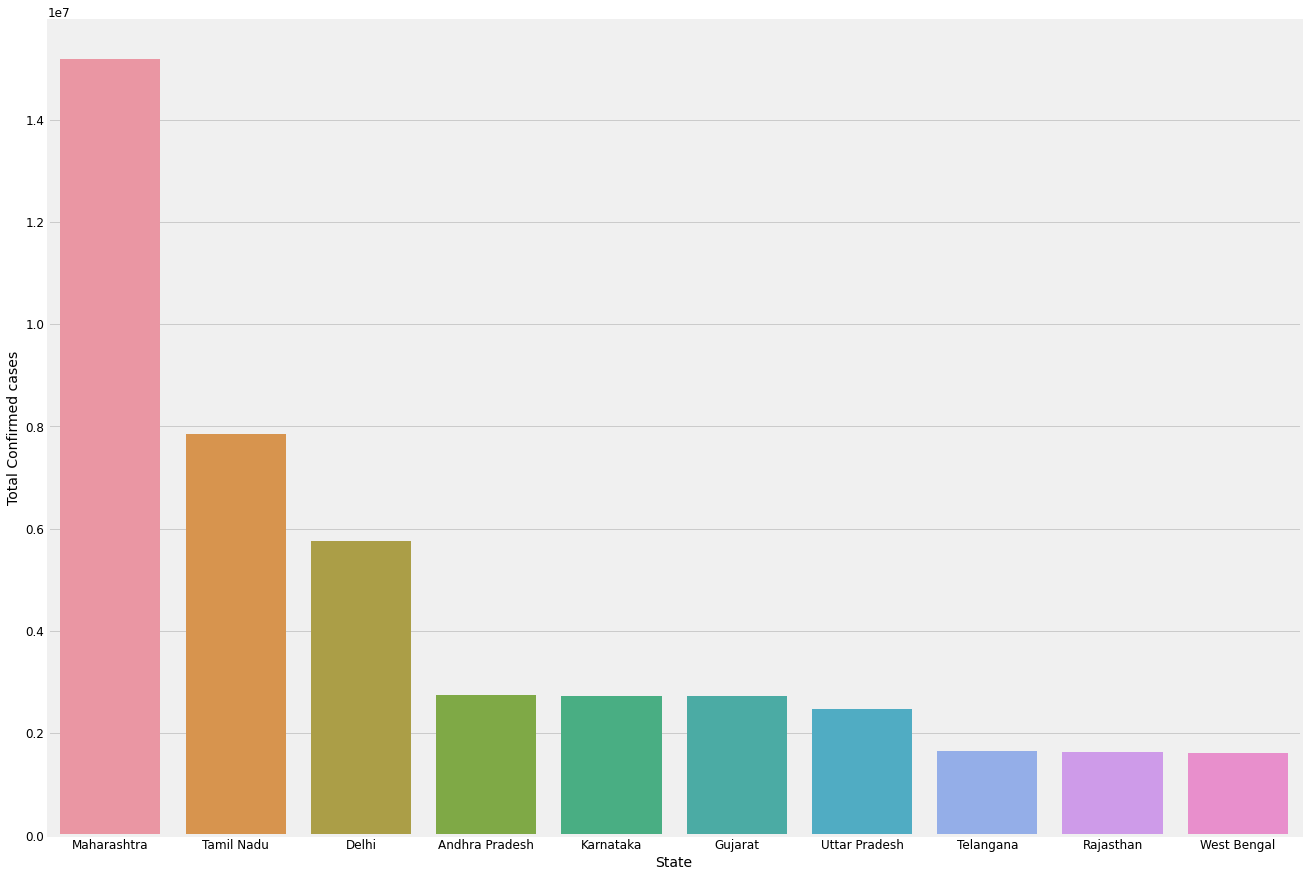

In [4]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Total Confirmed cases',inplace=True,ascending=False)
sns.barplot(y='Total Confirmed cases',x='State',data=statewisedata.iloc[:10])
# # statewisedata.plot.bar(rot=0,figsize=(20,10))
# # statewisedata.plot.bar(rot=0,figsize=(20,10))

# plt.xticks(rotation=70)
# statewisedata.head()

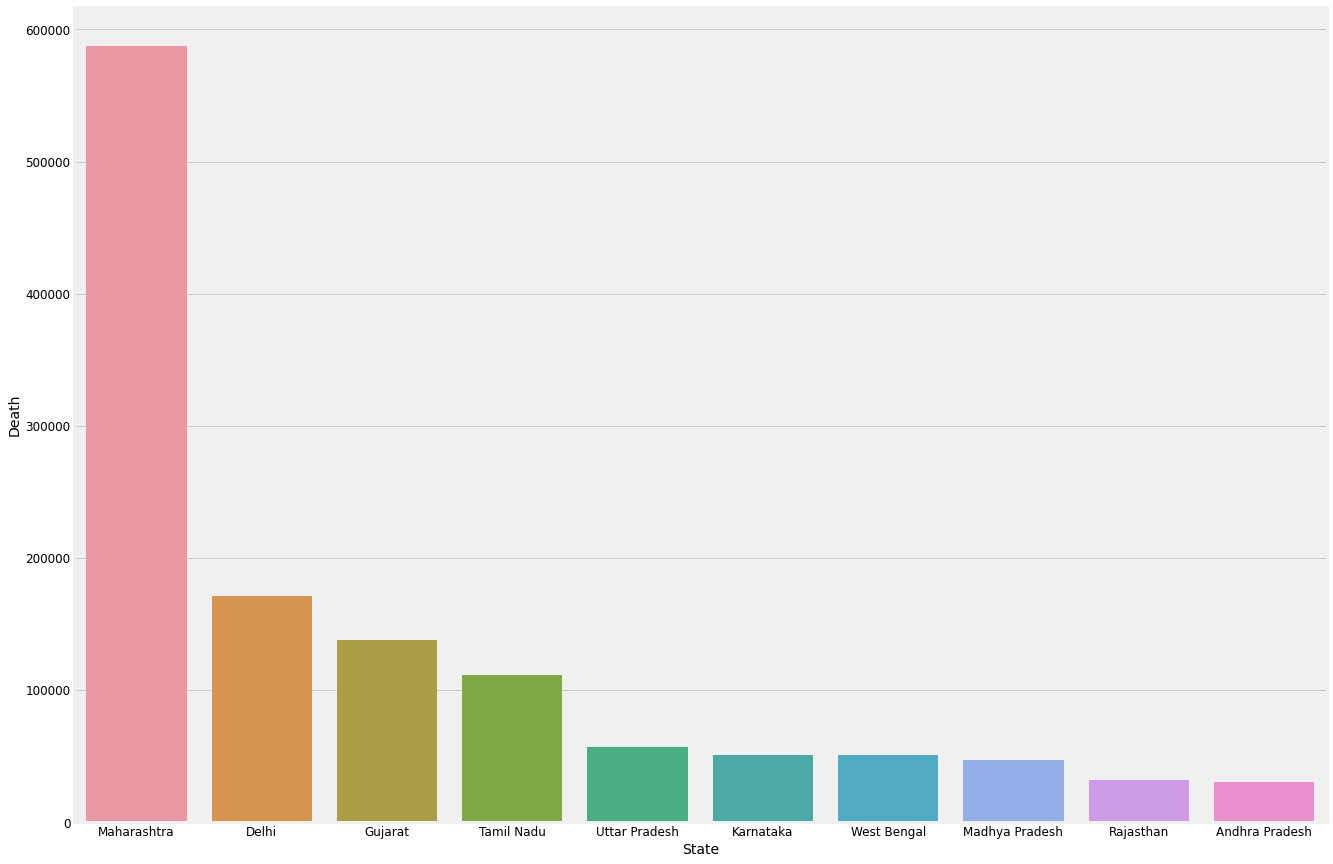

In [5]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Death',inplace=True,ascending=False)
sns.barplot(y='Death',x='State',data=statewisedata.iloc[:10])

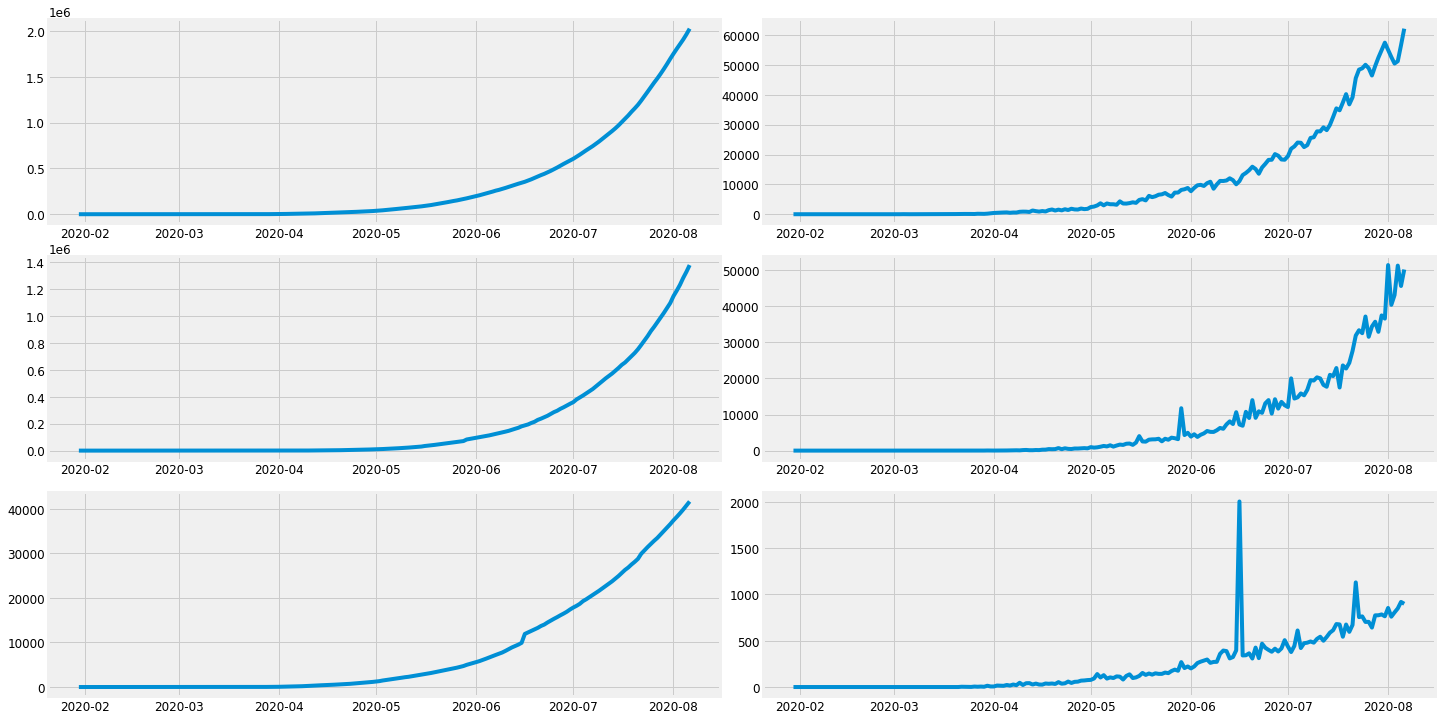

In [6]:
fig,ax=plt.subplots(3,2,figsize=(20,10))
fig.tight_layout()
ax[0,0].plot(indiadaily['Date'],indiadaily['cases'])
ax[0,1].plot(indiadaily['Date'],indiadaily['casesdaily'])
ax[1,0].plot(indiadaily['Date'],indiadaily['recovery'])
ax[1,1].plot(indiadaily['Date'],indiadaily['recoverydaily'])
ax[2,0].plot(indiadaily['Date'],indiadaily['death'])
ax[2,1].plot(indiadaily['Date'],indiadaily['deathdaily'])

# plt.plot(indiadaily['Date'],indiadaily['Total Recovered'])
# plt.plot(indiadaily['Date'],indiadaily['Total Deceased'])

In [7]:
indiatesting=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv')
indiatesting=indiatesting[['Tested As Of','Total Samples Tested']]
indiatesting['Tested As Of']=indiatesting['Tested As Of'].str.replace('/','-')
indiatesting.rename(columns={'Tested As Of':'Date','Total Samples Tested':'tests'},inplace=True)
indiatesting.dropna(how='any',axis=0,inplace=True)
indiatesting['Date']= indiatesting['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d-%m-%Y'))
indiatesting['Date']= pd.to_datetime(indiatesting['Date'])
indiatesting.head()

,Date,tests
0,2020-03-13,6500.0
1,2020-03-18,13125.0
2,2020-03-19,13316.0
3,2020-03-19,14175.0
4,2020-03-20,14376.0


In [9]:
indiacovidfinal = indiadaily.merge(indiatesting,how='inner',on='Date')

indiacovidfinal = indiacovidfinal[['Date','casesdaily', 'recoverydaily', 'recovery', 'deathdaily','death', 'tests', 'cases']]
indiacovidfinal.tail()

,Date,casesdaily,recoverydaily,recovery,deathdaily,death,tests,cases
141,2020-08-01,55117,51368,1146906,854,37420,19821831.0,1752185
142,2020-08-02,52672,40355,1187261,760,38180,20202858.0,1804857
143,2020-08-03,50488,43070,1230331,806,38986,20864750.0,1855345
144,2020-08-04,51282,51220,1281551,849,39835,21484402.0,1906627
145,2020-08-05,56626,45583,1327134,919,40754,22149351.0,1963253


In [10]:
indiacovidfinal.columns

Index(['Date', 'casesdaily', 'recoverydaily', 'recovery', 'deathdaily',
       'death', 'tests', 'cases'],
      dtype='object')

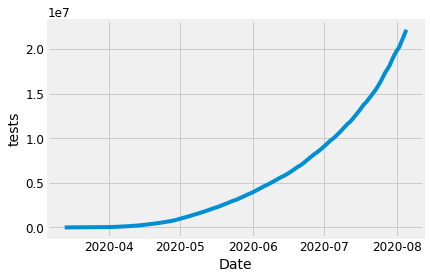

In [11]:
sns.lineplot(x='Date',y='tests',data=indiacovidfinal)

## EDA



In [12]:
indiacovidfinal=indiacovidfinal.groupby('Date').sum()
indiacovidfinal.sort_index(inplace= True)
indiacovidfinal.head()

,casesdaily,recoverydaily,recovery,deathdaily,death,tests,cases
Date,,,,,,,
2020-03-13,10,6,10,0,1,6500.0,91
2020-03-18,25,0,15,0,3,13125.0,171
2020-03-19,54,10,40,2,8,27491.0,396
2020-03-20,116,6,46,0,8,29780.0,512
2020-03-21,156,0,46,0,8,32612.0,668


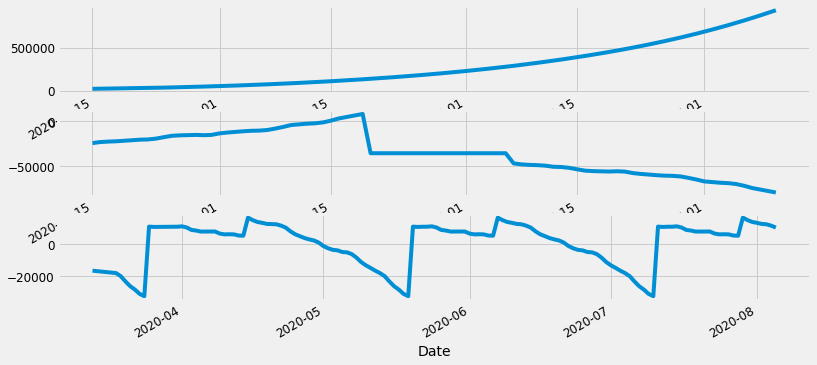

In [87]:
toplot=indiacovidfinal['cases']
result = seasonal_decompose(toplot, model='additive',freq=52)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,6))
result.trend.plot(ax=ax1)
result.resid.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
plt.show()

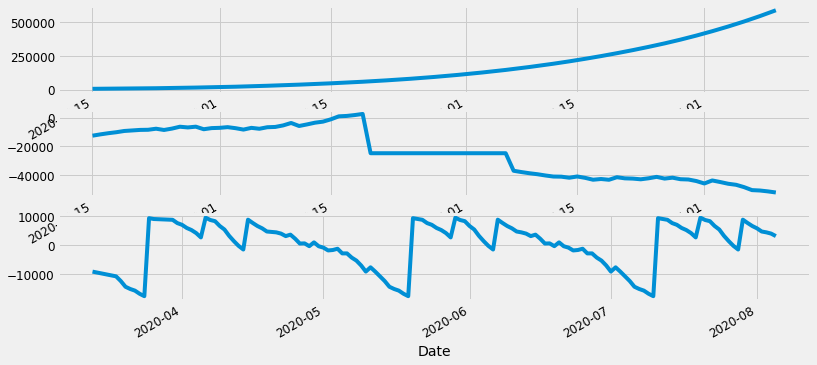

In [86]:
toplot=indiacovidfinal['recovery']
result = seasonal_decompose(toplot, model='additive',freq=52)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,6))
result.trend.plot(ax=ax1)
result.resid.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
plt.show()

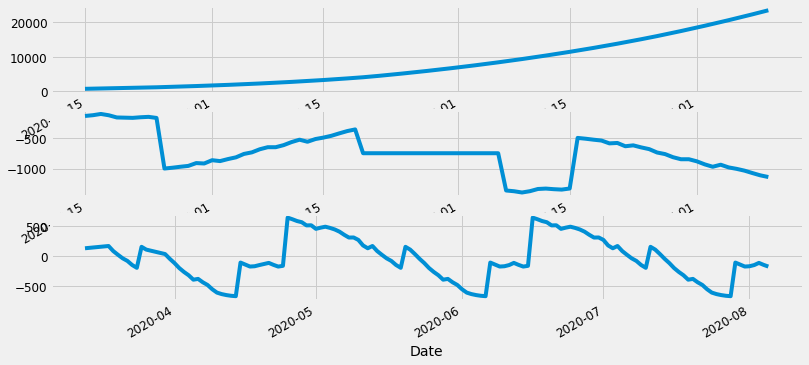

In [88]:
toplot=indiacovidfinal['death']
result = seasonal_decompose(toplot, model='additive',freq=52)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,6))
result.trend.plot(ax=ax1)
result.resid.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
plt.show()

## Stationarity Testing

In [15]:
result = adfuller(indiacovidfinal['cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.495026
p-value: 1.000000
	1%: -3.483
	5%: -2.885
	10%: -2.579


In [16]:
result = adfuller(indiacovidfinal['death'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 18.247325
p-value: 1.000000
	1%: -3.479
	5%: -2.883
	10%: -2.578


## LSTM

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(indiacovidfinal)

In [18]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

110 28
(110, 7)
(28, 7)


In [19]:
trainX, trainY = train[:,0:6],train[:,6]
testX, testY = test[:,0:6],test[:,6]

In [20]:
# trainY = np.insert(trainY, 0, 0)
# define generator
n_input = 1
generator = TimeseriesGenerator(trainX, trainY, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(testX, testY, length=n_input, batch_size=1)

In [21]:
n_features = 6
# trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))

In [89]:
lstm_model = Sequential()
lstm_model.add(LSTM(400, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse',metrics='mse')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               651200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 651,601
Trainable params: 651,601
Non-trainable params: 0
_________________________________________________________________


In [90]:
lstm_model.fit_generator(generator=generator,epochs=100)

Epoch 1/100
109/109 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 2/100
109/109 [==============================] - 0s 3ms/step - loss: 2.2096e-04 - mse: 2.2096e-04
Epoch 3/100
109/109 [==============================] - 0s 3ms/step - loss: 1.1152e-04 - mse: 1.1152e-04
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 6.1257e-05 - mse: 6.1257e-05
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 4.3271e-05 - mse: 4.3271e-05
Epoch 6/100
109/109 [==============================] - 0s 3ms/step - loss: 4.7021e-05 - mse: 4.7021e-05
Epoch 7/100
109/109 [==============================] - 0s 4ms/step - loss: 4.9056e-05 - mse: 4.9056e-05
Epoch 8/100
109/109 [==============================] - 0s 3ms/step - loss: 3.1796e-05 - mse: 3.1796e-05
Epoch 9/100
109/109 [==============================] - 0s 3ms/step - loss: 4.0075e-05 - mse: 4.0075e-05
Epoch 10/100
109/109 [==============================] - 0s 4ms/step - lo

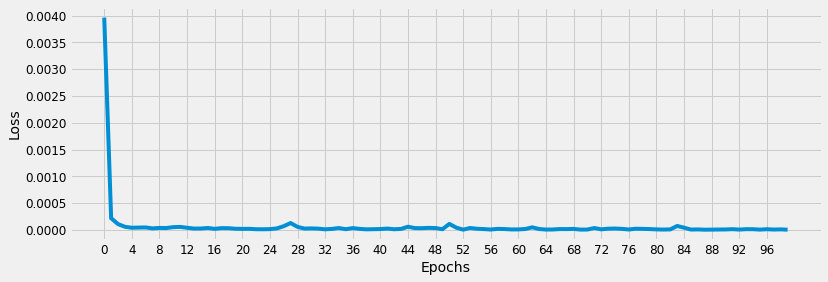

In [91]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,100,4))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [92]:
output=lstm_model.predict(generator_test)

In [93]:
toInverseScaleOuput = np.hstack((testX[0:len(testX)-1],output))
inverseScaledOutput=scaler.inverse_transform(toInverseScaleOuput)

inverseScaledActual=scaler.inverse_transform(test[0:len(test)-1])

In [94]:
inverseScaledActual[:,-1:],inverseScaledOutput[:,-1:]

(array([[ 794847.],
        [ 822609.],
        [ 850366.],
        [ 879472.],
        [ 907650.],
        [ 937567.],
        [ 970174.],
        [1005642.],
        [1040462.],
        [1077873.],
        [1118108.],
        [1154914.],
        [1194084.],
        [1239685.],
        [1288128.],
        [1337016.],
        [1387088.],
        [1436020.],
        [1482504.],
        [1532135.],
        [1584614.],
        [1639582.],
        [1697068.],
        [1752185.],
        [1804857.],
        [1855345.],
        [1906627.]]), array([[ 824897.27253515],
        [ 856469.81646967],
        [ 883698.69953686],
        [ 908752.70981747],
        [ 932308.24427396],
        [ 967902.07668042],
        [1004652.41274202],
        [1046074.98378575],
        [1072058.66690898],
        [1112879.90519774],
        [1152118.06684864],
        [1177029.78862369],
        [1223457.03021228],
        [1291861.29314888],
        [1341051.9272927 ],
        [1388770.06262577],
        [14

In [95]:
rms = sqrt(mean_squared_error(inverseScaledActual[:,-1:],inverseScaledOutput[:,-1:]))
print('RMSE : ',rms)

RMSE :  64743.6783328303


In [96]:
mae = mean_absolute_error(inverseScaledActual[:,-1:],inverseScaledOutput[:,-1:])
print('MAE :' ,mae)

MAE : 56124.446932916304
